# Construction & Comparaison de modèles

## Définition de la fonction de scoring

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

## Import d'un modèle de référence

<img src='https://divamgupta.com/assets/images/posts/imgseg/image12.png?style=centerme'>

In [18]:
%%time
## Encodeur
from tensorflow.keras.layers import Conv2D, Input,Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, concatenate, UpSampling2D
from keras_segmentation.models.model_utils import get_segmentation_model
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras

from keras_segmentation.models.unet import vgg_unet
import cv2
import tensorflow.keras as keras
import os



def call My_vgg_unet(Model):
    def __init__(self, input_shape_):
        self.input_shape_ = input_shape_
    
    
    def build_model(self):
        model_unet = vgg_unet(n_classes = 8, 
                              input_height=self.input_shape_[0], 
                              input_width =self.input_shape_[1])

        self = model_unet

## Construction d'un modèle via transfert learning

<img src='https://divamgupta.com/assets/images/posts/imgseg/image4.png?style=centerme'>

In [2]:
%%time

class My_ResNet50(Model):
    def __init__(self, img_input_shape):
        self.img_input_shape = img_input_shape
    
    
    def build_model(self):
        def predict_class(X):
            X = self.predict_generator(X)
            y_pred = []
            for x in X :
                p = []
                for u in x:
                    for i in u:
                        p.append(i.argmax())
                y_pred.append(np.array(p).reshape((model.input_shape[2], model.input_shape[1])))
            return y_pred
        
        def fit_model(n_epcoh):
            x_ = os.listdir('data/')
            y_ = os.listdir('label/')
            
            for n in range(n_epcoh):
                print(f'epoch {n}')
                X = np.array([cv2.resize(cv2.imread(f'data/{x_[n]}', 1), (256, 512))])
                y = np.array([cv2.resize(cv2.imread(f'label/{y_[n]}',0), (256, 512))])
                y = to_categorical(y)
                
                self.fit(X[:1], y[:1])

            
        base_model = keras.applications.ResNet50(include_top=False, 
                                                 input_shape=self.img_input_shape, 
                                                 weights="imagenet")
        for layer in base_model.layers:
            layer.trainable = False
        
        

        out = Conv2D(8, (32, 32), activation='softmax', 
                     padding='same')(UpSampling2D((32, 32))(base_model.output))
        
        self = Model(base_model.input ,  out)
        self.fit_model = fit_model
        return self

CPU times: user 78 µs, sys: 1e+03 ns, total: 79 µs
Wall time: 83 µs


## Construction d'un modèle de convolution


[A compléter]

<img src='https://divamgupta.com/assets/images/posts/imgseg/image6.png?style=centerme'>

In [ ]:
class My_Model_(Model):
    def __init__(self, input_shape_):
        self.input_shape_ = input_shape_
        self.model = None
        
    def build_model(self):
        def predict_class(X):
            X = self.predict_generator(X)
            y_pred = []
            for x in X :
                p = []
                for u in x:
                    for i in u:
                        p.append(i.argmax())
                y_pred.append(np.array(p).reshape((model.input_shape_[2], model.input_shape_[1])))
            return y_pred
        
        
        img_input = Input(shape=self.input_shape_)

        
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
        conv1 = Dropout(0.2)(conv1)
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)

        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = Dropout(0.2)(conv2)
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)


        ## Décodeur
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = Dropout(0.2)(conv3)
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

        up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
        conv4 = Dropout(0.2)(conv4)
        conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

        up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
        conv5 = Dropout(0.2)(conv5)
        conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

        out = Conv2D(8, (1, 1) , padding='same', activation='softmax')(conv5)

        model = Model(img_input ,  out)
        self = model
        self.predict_class = predict_class
        return self

# Entrainement des modèles

## Entrainement du modèl Unet

In [20]:
%%time
model.train( 
    train_images =  "data/",
    train_annotations = "label copie/",
    checkpoints_path = "checkpoints/vgg_unet_1" , epochs=5
)

Verifying training dataset


100%|███████████████████████████████████████| 3475/3475 [03:10<00:00, 18.23it/s]
/Users/kevinduranty/miniforge3/envs/p8/lib/python3.8/site-packages/keras_segmentation/train.py:156: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, steps_per_epoch,


Dataset verified! 
Epoch 1/5


2022-02-22 15:35:04.979200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


512/512 [==============================] - 1503s 3s/step - loss: 2.2832 - accuracy: 0.2414
Epoch 2/5
512/512 [==============================] - 1515s 3s/step - loss: 1.8791 - accuracy: 0.4667
Epoch 3/5
512/512 [==============================] - 1504s 3s/step - loss: 1.7142 - accuracy: 0.5146
Epoch 4/5
512/512 [==============================] - 1502s 3s/step - loss: 1.6343 - accuracy: 0.5273
Epoch 5/5
512/512 [==============================] - 1509s 3s/step - loss: 1.5860 - accuracy: 0.5341
CPU times: user 18min 25s, sys: 1h 5min 25s, total: 1h 23min 50s
Wall time: 2h 8min 44s


In [21]:
model.save('my_vgg_unet')

INFO:tensorflow:Assets written to: my_vgg_unet/assets


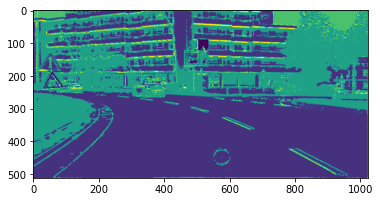

In [44]:
plt.imshow(model.predict_segmentation(inp='data/aachen_000000_000019_leftImg8bit.png'))


## Entrainement du model CNN

* <b> Entrainement simple</b>

In [3]:
%%time
import pandas as pd
from class_ import MY_Generator

img_input_shape = (1024, 2048,1)
model = My_Model_(img_input_shape).model_function()

df = pd.read_csv('data.csv')

my_training_batch_generator = MY_Generator(df.id[:100], 2)
my_validation_batch_generator = MY_Generator(df.id[100:140], 2)


model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=5,
                    verbose=1,
                    workers=2
                    )

y_pred = model.predict_class(my_validation_batch_generator)

Epoch 1/5


<timed exec>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
2022-02-21 21:08:03.476098: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-21 21:08:03.807730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.2864

2022-02-21 21:11:00.104708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 184s 4s/step - loss: 0.5528 - accuracy: 0.2864 - val_loss: 0.3760 - val_accuracy: 0.4136
Epoch 2/5
50/50 [==============================] - 184s 4s/step - loss: 0.3588 - accuracy: 0.3735 - val_loss: 0.3403 - val_accuracy: 0.4184
Epoch 3/5
50/50 [==============================] - 183s 4s/step - loss: 0.3287 - accuracy: 0.4345 - val_loss: 0.3079 - val_accuracy: 0.5221
Epoch 4/5
50/50 [==============================] - 184s 4s/step - loss: 0.2828 - accuracy: 0.5063 - val_loss: 0.2626 - val_accuracy: 0.5291
Epoch 5/5
50/50 [==============================] - 183s 4s/step - loss: 0.2621 - accuracy: 0.5349 - val_loss: 0.2633 - val_accuracy: 0.5428
CPU times: user 3min 6s, sys: 8min 31s, total: 11min 38s
Wall time: 15min 18s


* <b> Entrainement avec réduction de la taille des images + génération aléatoire d'image</b>

In [53]:
import pandas as pd
from class_ import MY_Generator

img_input_shape = (512, 256,1)
model = My_Model_(img_input_shape).model_function()

df = pd.read_csv('data.csv')

my_training_batch_generator = MY_Generator(df.id[:200], 2, red_shape = (256, 512))
my_validation_batch_generator = MY_Generator(df.id[200:240], 2, red_shape = (256, 512))


model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit_generator(generator=my_training_batch_generator,
                    validation_data=my_validation_batch_generator,
                    epochs=15,
                    verbose=1,
                    use_multiprocessing=True,
                    workers=4
                    )

Epoch 1/15


/var/folders/pd/d9xkkvws5r5f_x34lthx34ph0000gn/T/ipykernel_24920/956540758.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=my_training_batch_generator,
2022-02-21 22:28:50.267039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.4392

2022-02-21 22:29:14.454293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 28s 248ms/step - loss: 0.3524 - accuracy: 0.4392 - val_loss: 0.2935 - val_accuracy: 0.5338
Epoch 2/15
100/100 [==============================] - 27s 247ms/step - loss: 0.2589 - accuracy: 0.5745 - val_loss: 0.2613 - val_accuracy: 0.5578
Epoch 3/15
100/100 [==============================] - 27s 248ms/step - loss: 0.2205 - accuracy: 0.6348 - val_loss: 0.2184 - val_accuracy: 0.6407
Epoch 4/15
100/100 [==============================] - 27s 247ms/step - loss: 0.2028 - accuracy: 0.6691 - val_loss: 0.2257 - val_accuracy: 0.6449
Epoch 5/15
100/100 [==============================] - 27s 247ms/step - loss: 0.1867 - accuracy: 0.7058 - val_loss: 0.2135 - val_accuracy: 0.6315
Epoch 6/15
100/100 [==============================] - 27s 247ms/step - loss: 0.1764 - accuracy: 0.7230 - val_loss: 0.1928 - val_accuracy: 0.6794
Epoch 7/15
100/100 [==============================] - 27s 248ms/step - loss: 0.1722 - accuracy: 0.7271 - val_loss: 0.1953 - val_accuracy: 0.6

<timed exec>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
2022-02-21 22:35:39.073920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


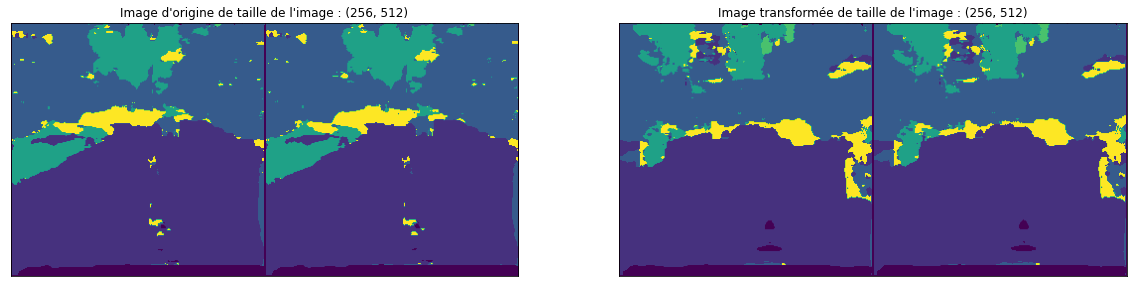

In [54]:
import matplotlib.pyplot as plt
def show_2img(img, img_):
    plt.figure(figsize=(20,12))
    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Image d'origine de taille de l'image : {img.shape}")
    plt.imshow(img)
    
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Image transformée de taille de l'image : {img.shape}")
    plt.imshow(img_)
    plt.show()

y = model.predict_class(my_validation_batch_generator)
show_2img(y[0], y[1])

## Entrainement du model Resnet

In [ ]:
import numpy as np
import cv2
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical



base_model = My_ResNet50(img_input_shape).build_model()
base_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])


base_model.fit_model(5)

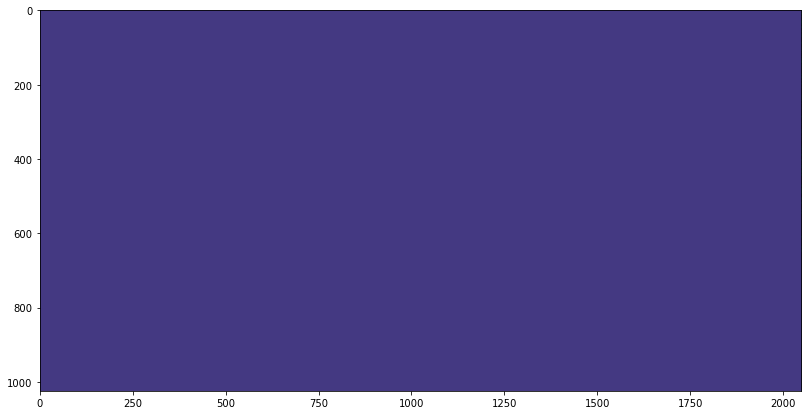

In [249]:
plt.figure(figsize=(20,7))
plt.imshow(p)
plt.show()

## Entrainement d'un modèl keras vgg_unet

# Evaluation des modèles